<a href="https://colab.research.google.com/github/widushak/CLV-models/blob/master/HierarchicalBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz==0.8.0
!pip install pymc3>=3.8
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.5MB 5.7MB/s 
     |████████████████████████████████| 4.7MB 21.7MB/s 
     |████████████████████████████████| 296kB 38.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
df1=pd.read_excel('/content/drive/MyDrive/online_retail_kaggle.xlsx',sheet_name='Year 2009-2010')
df2=pd.read_excel('/content/drive/MyDrive/online_retail_kaggle.xlsx',sheet_name='Year 2010-2011')
combine=[df1,df2]
df=pd.concat(combine)

In [33]:
df.rename(columns={'Customer ID':'CustomerID'},inplace=True)
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']).dt.date
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']).dt.date
df['Invoicemonth']=df['InvoiceDate'].map(lambda date: 100*date.year+date.month)
#df = df[df['Invoicemonth']>200912]
df=df[df['Quantity']>0]
df=df[df['CustomerID'].notnull()==True]
df['Total_amt']=df['Quantity']*df['Price']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Invoicemonth,Total_amt
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,200912,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,200912,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,200912,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,200912,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,200912,30.00
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,201112,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,201112,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,201112,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France,201112,14.85


In [34]:
!pip install lifetimes

In [35]:
from lifetimes.utils import calibration_and_holdout_data 
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np
#calibration_end='2010-12-31'
#observation_end = '2011-06-30'
#rfm = summary_data_from_transaction_data(
    #df,
   # 'CustomerID',
  #  'InvoiceDate',
   # observation_period_end=pd.to_datetime('2011-06-30'),
    #freq='W'
#)
rfm = calibration_and_holdout_data(
    df,
    'CustomerID',
    'InvoiceDate',
    calibration_period_end='2011-06-30',
    observation_period_end='2011-12-09',
    freq='W'
)

rfm.shape
rfm.shape

(5043, 5)

In [36]:
from pymc3.math import exp, log

class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))

In [61]:

# Extract data for model following notation from Fader/Hardie
N = rfm.shape[0] # number of customers
x = rfm['frequency_cal'].values
t_x = rfm['recency_cal'].values
T = rfm['T_cal'].values # length of training period

n_draws = 2000

pnbd_model = pm.Model()

with pnbd_model:
    
    # Uninformative priors on model hyperparameters see Polson and Scott 
    # https://projecteuclid.org/download/pdfview_1/euclid.ba/1354024466
    r = pm.HalfCauchy('r', beta=2)
    alpha = pm.HalfCauchy('alpha', beta=2)
    s = pm.HalfCauchy('s', beta=2)
    beta = pm.HalfCauchy('beta', beta=2)
    
    # Gamma prior on purchasing rate parameter lambda
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N, testval=np.random.rand(N))
    # Gamma prior on lifetime parameter mu
    mu = pm.Gamma('mu', alpha=s, beta=beta, shape=N, testval=np.random.rand(N))

    # Custom distribution for Pareto-NBD likelihood function
    loglikelihood = ParetoNBD("loglikelihood", mu=mu, lambda_=lambda_, observed={'x': x, 't_x': t_x, 'T': T})
    
    # Sample the model
    trace = pm.sample(n_draws,tune=2000, init=None)
    #posterior_pred_1 = pm.sample_posterior_predictive(trace)

Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda, beta, s, alpha, r]
100%|██████████| 4000/4000 [19:56<00:00,  3.34it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [62]:
tr=pm.backends.tracetab.trace_to_dataframe(trace, chains=None, varnames=None, include_transformed=False)

In [63]:
tr.dropna()

,r,alpha,s,beta,lambda__0,lambda__1,lambda__2,lambda__3,lambda__4,lambda__5,lambda__6,lambda__7,lambda__8,lambda__9,lambda__10,lambda__11,lambda__12,lambda__13,lambda__14,lambda__15,lambda__16,lambda__17,lambda__18,lambda__19,lambda__20,lambda__21,lambda__22,lambda__23,lambda__24,lambda__25,lambda__26,lambda__27,lambda__28,lambda__29,lambda__30,lambda__31,lambda__32,lambda__33,lambda__34,lambda__35,...,mu__5003,mu__5004,mu__5005,mu__5006,mu__5007,mu__5008,mu__5009,mu__5010,mu__5011,mu__5012,mu__5013,mu__5014,mu__5015,mu__5016,mu__5017,mu__5018,mu__5019,mu__5020,mu__5021,mu__5022,mu__5023,mu__5024,mu__5025,mu__5026,mu__5027,mu__5028,mu__5029,mu__5030,mu__5031,mu__5032,mu__5033,mu__5034,mu__5035,mu__5036,mu__5037,mu__5038,mu__5039,mu__5040,mu__5041,mu__5042
0,0.822950,12.649971,1.595685,572.734817,0.040050,0.080673,0.084531,0.029786,0.020945,0.035019,0.128881,0.051602,0.047905,0.073675,0.248279,0.014171,0.018913,0.129649,0.016480,0.071342,0.020775,0.054130,0.046938,0.004652,0.000488,0.020413,0.021238,0.013524,0.096727,0.008898,0.043399,0.044594,0.035982,0.019190,0.024619,0.085910,0.137232,0.037818,0.012340,0.003107,...,0.001560,0.001532,0.002238,0.005640,0.002962,0.002924,0.003659,0.000808,0.001989,0.000836,0.008600,0.000146,0.000159,0.005472,0.003667,0.002790,0.001663,0.002791,0.004590,0.001733,0.001766,0.004915,0.002182,0.000131,0.001403,0.001961,0.005636,0.002896,0.002719,0.002157,0.000587,0.000658,0.000312,0.000836,0.003750,0.003427,0.007119,0.001295,0.003361,0.003166
1,0.815700,12.806992,1.537821,528.423869,0.044150,0.034121,0.079860,0.019643,0.015522,0.013184,0.100232,0.031806,0.009371,0.009642,0.044110,0.031850,0.070381,0.075355,0.023455,0.038970,0.036826,0.001117,0.006016,0.031458,0.000297,0.064868,0.025870,0.024300,0.017647,0.076239,0.007721,0.049906,0.026837,0.007455,0.028524,0.046640,0.063950,0.002946,0.128869,0.001350,...,0.004755,0.001455,0.002422,0.000849,0.002217,0.000980,0.004239,0.002169,0.004065,0.003227,0.001198,0.001927,0.010813,0.001358,0.003759,0.003346,0.000606,0.002864,0.001952,0.001505,0.005722,0.000598,0.002152,0.000096,0.004766,0.006838,0.001381,0.001248,0.002231,0.008190,0.004430,0.000855,0.013928,0.001482,0.003005,0.001562,0.002766,0.003792,0.003816,0.002581
2,0.744634,11.314048,1.538236,496.070390,0.093855,0.082651,0.031269,0.065278,0.006226,0.023088,0.226391,0.008589,0.018537,0.052712,0.166329,0.005874,0.010991,0.086203,0.062712,0.023724,0.028744,0.000117,0.007566,0.011327,0.025470,0.014794,0.056249,0.023621,0.011811,0.006016,0.040657,0.041154,0.080234,0.024092,0.054676,0.065723,0.107600,0.039804,0.008649,0.007948,...,0.001774,0.005445,0.001443,0.005631,0.003532,0.004947,0.001794,0.003124,0.001065,0.003783,0.004387,0.003669,0.000447,0.002052,0.003528,0.000773,0.006440,0.001556,0.003054,0.001690,0.001983,0.009690,0.008164,0.015276,0.002661,0.000799,0.001441,0.000951,0.003589,0.000406,0.001999,0.008944,0.000120,0.001422,0.000929,0.000894,0.001702,0.002820,0.001923,0.002588
3,0.794581,12.447531,1.593789,519.701714,0.086032,0.099503,0.115741,0.031100,0.072655,0.026434,0.083625,0.008320,0.079095,0.021839,0.095901,0.007242,0.016056,0.135730,0.054905,0.013386,0.061638,0.017563,0.077365,0.006100,0.002264,0.001734,0.030070,0.020397,0.125690,0.029955,0.035835,0.041129,0.077374,0.004587,0.029671,0.068596,0.274717,0.005207,0.020705,0.044148,...,0.001731,0.001775,0.008577,0.004324,0.006463,0.003088,0.005067,0.007269,0.000426,0.005098,0.003029,0.004765,0.000393,0.006260,0.002048,0.004067,0.001526,0.004536,0.002354,0.000949,0.002149,0.001999,0.002762,0.001235,0.000393,0.002034,0.002488,0.001771,0.000559,0.000589,0.001380,0.003026,0.001972,0.004766,0.002827,0.001023,0.002261,0.001708,0.000701,0.002171
4,0.792365,12.370614,1.564278,523.162160,0.068407,0.035703,0.051245,0.030406,0.001678,0.015365,0.132297,0.101550,0.019815,0.020317,0.099288,0.004049,0.020443,0.054090,0.087904,0.096842,0.010401,0.013284,0.012344,0.004469,0.044775,0.220818,0.069666,0.023394,0.015612,0.032362,0.017943,0.041603,0.016508,0.029868,0.03696

In [64]:
r=np.array(tr['r'])
alpha=np.array(tr['alpha'])
s=np.array(tr['s'])
beta=np.array(tr['beta'])

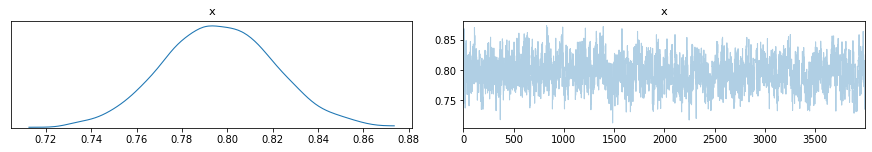

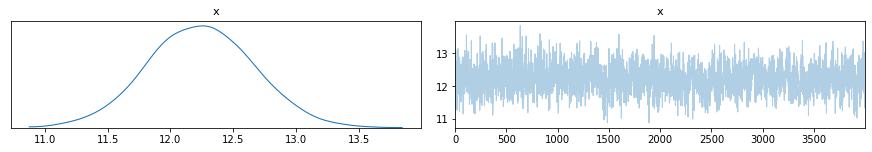

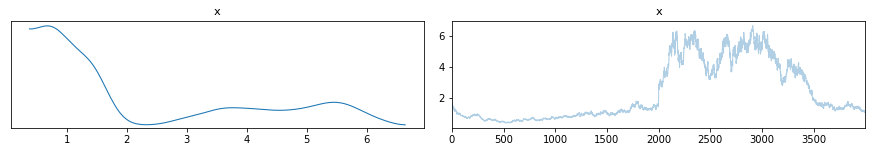

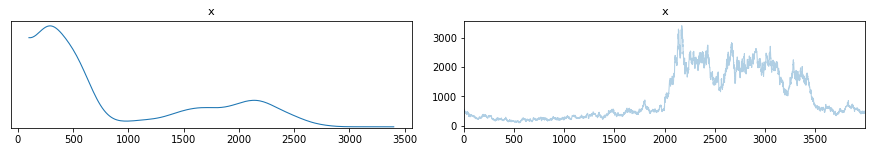

In [65]:
_ = pm.traceplot(r)
_ = pm.traceplot(alpha)
_ = pm.traceplot(s)
_ = pm.traceplot(beta)

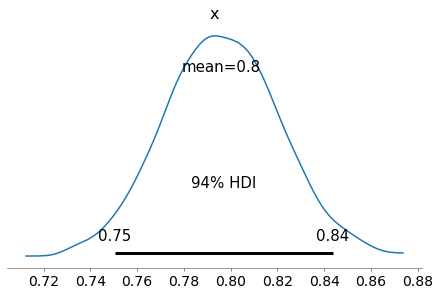

In [66]:
_ = pm.plot_posterior(r)

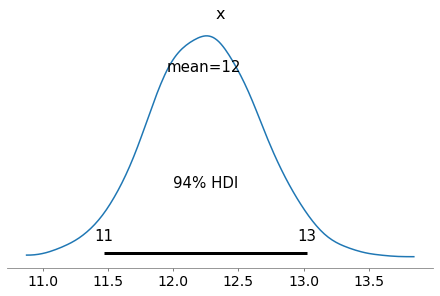

In [67]:
_ = pm.plot_posterior(alpha)

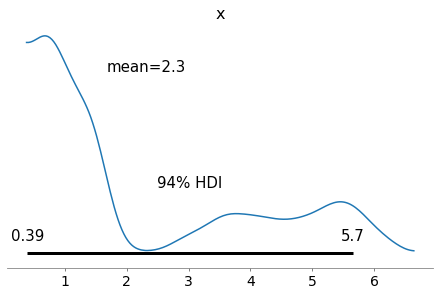

In [68]:
_ = pm.plot_posterior(s)

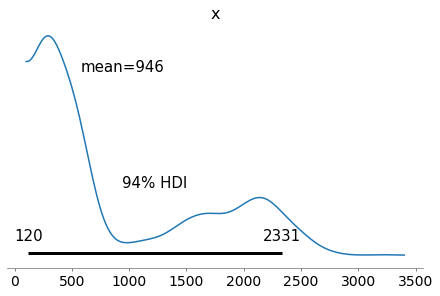

In [69]:
_ = pm.plot_posterior(beta)

In [70]:
def prob_alive_at_T(lambda_, mu, t_x, T):
    """
    Probability a customer's time of death \tau occurs after T.
    
    Pr(\tau > T \> | \> \lambda, \mu, x, t_x,T) = \dfrac{1}{1+\dfrac{\mu}{\mu+\lambda}
    \big\{e^{(\lambda+\mu)(T-t_x)}-1\big\}}
    
    See expression (7) in technical appendix of Abe.
    
    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar
    :param mu: mu parameter at the customer level
    :type mu_: scalar
    :param t_x: recency of transactions
    :type t_x: float
    :param T: duration of the calibration/training period
    :type T: float
    
    :return: probability of being alive at time T.
    """

    den = 1 + (mu / (lambda_ + mu)) * (np.exp((lambda_ + mu) * (T - t_x)) - 1)
    return 1 / den

In [71]:
def likelihood(lambda_, mu, x, t, T):
    """Pareto/NBD likelihood function.

    :param lambda_: lambda parameter at the customer-level.
    :param mu: mu parameter at the customer level
    :param x: number of repeat transactions
    :param t: recency
    :param T: length of the calibration/training period.

    :return: likelihood value.
    """

    p1 = x * np.log(lambda_) + np.log(mu) - np.log(mu + lambda_) - t * (mu + lambda_)
    p2 = (x + 1) * np.log(lambda_) - np.log(mu + lambda_) - T * (mu + lambda_)
    return np.exp(p1) + np.exp(p2)
def predict(t, lambda_, mu, x, tx, T):
    """Conditional expected purchases at end of time (T, T+t).

    Used to assess holdout period performance and to make predictions
    for future time period t. Conditional on purchase history (x, t_x, T).

    E[X(T,T+t) \> | \> \lambda, \mu, x, t_x, T] = \dfrac{1}{L(\lambda, \mu)|(x, t_x, T)}
    \times \dfrac{\lambda^{x+1}}{\mu}e^{-(\lambda+\mu)T}(1-e^{-\mu t})

    http://brucehardie.com/notes/034/corr_Pareto-NBD.pdf

    :param t: time period
    :type t: scalar

    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar

    :param mu: mu parameter at the customer level
    :type mu_: scalar

    :param x: number of repeat transactions
    :type x: integer

    :param tx: recency of transactions
    :type tx: float

    :param T: duration of the calibration/training period
    :type T: float

    :return expected number of purchases (scalar)
    """
    like = likelihood(lambda_, mu, x, tx, T)
    p2 = lambda_ ** (x + 1) / mu * np.exp(-(lambda_ + mu) * T) * (1 - np.exp(-mu * t))

    return 1 / like * p2

#Model Checking

In [72]:
rfm = calibration_and_holdout_data(
    df,
    'CustomerID',
    'InvoiceDate',
    calibration_period_end='2011-06-30',
    observation_period_end='2011-12-09',
    freq='W'
)

rfm.shape

(5043, 5)

In [73]:
rfm['frequency_cal'].describe()

count    5043.000000
mean        3.569106
std         6.251706
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        78.000000
Name: frequency_cal, dtype: float64

In [74]:
rfm['frequency_holdout'].describe()

count    5043.000000
mean        1.340670
std         2.269729
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        24.000000
Name: frequency_holdout, dtype: float64

In [75]:

customer_index = 120
# show purchasing behavior
rfm.iloc[customer_index]

frequency_cal         0.0
recency_cal           0.0
T_cal                25.0
frequency_holdout     0.0
duration_holdout     23.0
Name: 12489.0, dtype: float64

In [76]:
lambda_post = trace['lambda']
mu_post = trace['mu']

# Select distributions of lambda and mu for a customer
lambda_individual = lambda_post[:,customer_index]
mu_individual = mu_post[:,customer_index]

# predict purchases for the user at t = 39
t = 23
predict(t, lambda_individual, mu_individual, x[customer_index], t_x[customer_index], T[customer_index]).mean()

0.44176078450066597

In [77]:
t = 23
# predictions are size of customer base x number of draws
holdout_predictions = np.empty([N, n_draws])

for i in np.arange(N):
    holdout_predictions[i] = predict(
        t, 
        lambda_post[2000:,i], 
        mu_post[2000:,i], 
        x[i], 
        t_x[i], 
       T[i]
    )

# predictions are posterior mean
rfm['frequency_predicted'] = holdout_predictions.mean(axis=1)

In [78]:
rfm.shape

(5043, 6)

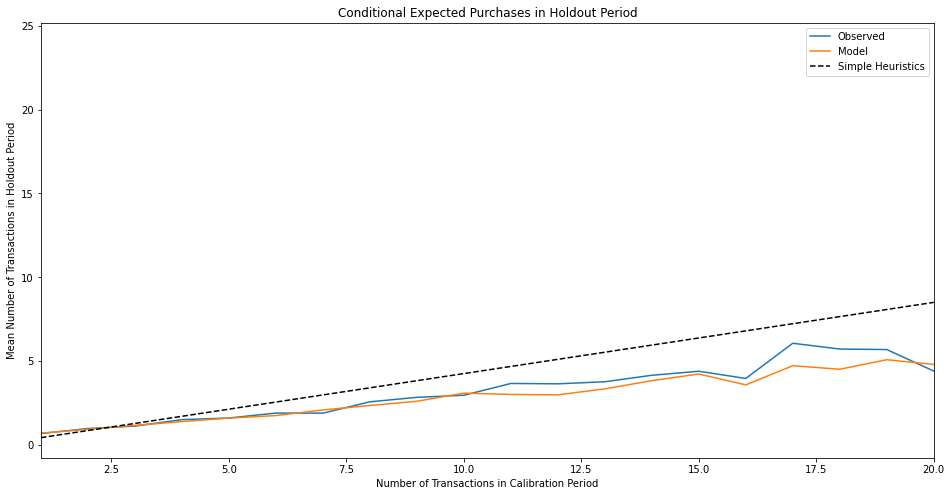

In [79]:
xlim=(1, 20)
mean_frequencies = rfm.groupby('frequency_cal')[['frequency_holdout',
                                     'frequency_predicted']].mean()
mean_frequencies.rename(columns={'frequency_holdout': 'Observed',
                                 'frequency_predicted': 'Model'},
                        inplace=True)
mean_frequencies.plot(kind='line',
                      title='Conditional Expected Purchases in Holdout Period', figsize=(16, 8))

# Generate a dummy model with holdout freq = t_holdout/t_calib
t_calib = np.mean(rfm['T_cal'])
t_holdout = t
x_heuristics = np.linspace(xlim[0],xlim[1],100)
heuristics = t_holdout/t_calib * x_heuristics

plt.plot(x_heuristics, heuristics, linestyle='--', color='black', label='Simple Heuristics')
plt.legend(loc=0)
plt.xlim(xlim)
plt.ylabel('Mean Number of Transactions in Holdout Period')
plt.xlabel('Number of Transactions in Calibration Period')
plt.grid(False)
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error
print("RMSE: %s" % np.sqrt(mean_squared_error(rfm['frequency_holdout'], rfm['frequency_predicted'])))

RMSE: 1.4012146008030926


In [81]:
t = 23
# predictions are size of customer base x number of draws
prob_predictions = np.empty([N, n_draws])

for i in np.arange(N):
    prob_predictions[i] = prob_alive_at_T( 
        lambda_post[2000:,i], 
        mu_post[2000:,i], 
        t_x[i], 
       T[i]
    )

# predictions are posterior mean
rfm['alive_predicted'] = prob_predictions.mean(axis=1)


In [82]:
col=['frequency_holdout']
rfm['alive_act'] = rfm.apply(lambda x: 1 if(x[col[0]] >0) else 0 , axis = 1)
col=['frequency_predicted']
rfm['alive_pred'] = rfm.apply(lambda x: 1 if(x[col[0]] >=1 ) else 0 , axis = 1)

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(rfm['alive_act'], rfm['alive_pred'])

array([[2073,  441],
       [ 928, 1601]])

In [84]:
from sklearn.metrics import classification_report
print(classification_report(rfm['alive_act'], rfm['alive_pred']))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2514
           1       0.78      0.63      0.70      2529

    accuracy                           0.73      5043
   macro avg       0.74      0.73      0.73      5043
weighted avg       0.74      0.73      0.73      5043

